# Импорты

In [3]:
from pathlib import Path  #Для работы с путями файлов
import psutil #Для контроля за памятью
import gc #Для запуска коллектора и отчистки памяти
import json #для работы с json
from matplotlib import pyplot as plt
import seaborn as sns #красивые картинки
import numpy as np

#Непосредственно для работы 
import pandas as pd
from dask import dataframe as dd

# Объявление функций

In [4]:
def display_memory():
    # Получаем общее количество доступной оперативной памяти
    total_memory = psutil.virtual_memory().total / (1024 ** 3)
    print(f'Общее количество ОЗУ: {total_memory:.2f} GB')

    # Получаем текущее использование оперативной памяти
    used_memory = psutil.virtual_memory().used / (1024 ** 3)
    print(f'Используется ОЗУ: {used_memory:.2f} GB')

# Dask основные шаги для работы

## Чтение данных

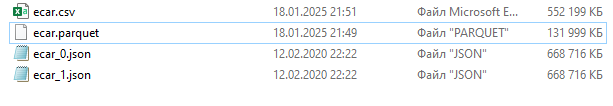

In [7]:
#Локально из parquet
df = dd.read_parquet(Path('D:/DF/MitUP/1/ecar.parquet'), \
                     columns = ['timestamp', 'id', 'hostname', 'objectID', 'object', 'action', 'actorID', 'pid', 'ppid', 'principal', 'properties'])
df

,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,principal,properties
npartitions=1,,,,,,,,,,,
,"datetime64[ns, pytz.FixedOffset(-240)]",string,string,string,string,string,string,int64,int64,string,string
,...,...,...,...,...,...,...,...,...,...,...


In [13]:
# Локально из json (если lines=True обязательно надо задать размер иначе скачается все в один partition)
df = dd.read_json(Path('D:/DF/MitUP/1/ecar_1.json'), errors ='strict', lines=True, blocksize = 6553600) 
df

,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties
npartitions=104,,,,,,,,,,,,
,"datetime64[ns, UTC-04:00]",string,string,string,string,string,string,int64,int64,int64,string,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
# Локально из CSV
df = dd.read_csv(Path('D:/DF/MitUP/1/ecar.csv'), sep = ';', parse_dates=['timestamp']) 
df

,Unnamed: 0,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties
npartitions=8,,,,,,,,,,,,,
,int64,"datetime64[ns, UTC-04:00]",string,string,string,string,string,string,int64,int64,int64,float64,string
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
#Локально из нескольких файлов с одинаковыми именами, заканчивающимися строками "_1" ... "_2"
df = dd.read_json(Path('D:/DF/MitUP/1/ecar_*.json'), errors ='ignore', lines=True, blocksize = 419430400)   
df

,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties
npartitions=2,,,,,,,,,,,,
,"datetime64[ns, UTC-04:00]",string,string,string,string,string,string,int64,int64,int64,string,string
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


# Запись

In [19]:
#В csv
df.to_csv(Path('D:/DF/MitUP/1/csv/'), index = False, sep = ';')

['D:\\DF\\MitUP\\1\\csv\\0.part', 'D:\\DF\\MitUP\\1\\csv\\1.part']

In [20]:
#Запись в паркет
df.to_parquet(Path('D:/DF/MitUP/1/parquet/'))

In [21]:
#Запись в дерево
df['year'] = df['timestamp'].dt.year
df['quart'] = df['timestamp'].dt.quarter
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df.to_parquet(Path('D:/DF/MitUP/1/tree/'), partition_on=["year", "month", "day"])

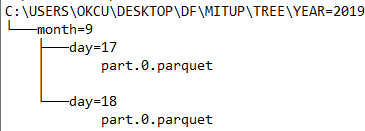

In [17]:
#Чтение Из иерархического дерева каталогов, только определенные дни
df = dd.read_parquet(Path('C:/Users/OkCu/Desktop/DF/MitUP/tree'), filters=[("day", ">", 17)])   
df

,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties,quart,year,month,day
npartitions=2,,,,,,,,,,,,,,,,
,"datetime64[ns, pytz.FixedOffset(-240)]",string,string,string,string,string,string,int64,int64,int64,string,string,int32,category[known],category[known],category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [29]:
#Чтение из папаки, созданной dask
df = dd.read_csv(Path('C:/Users/OkCu/Desktop/DF/MitUP/csv/*'), sep = ';')
df

,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties
npartitions=16,,,,,,,,,,,,
,string,string,string,string,string,string,string,int64,int64,int64,float64,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


# Изучение Dask DataFrame

## Сначала на простых данных

In [25]:
ddf = pd.DataFrame({'a': [3, 4, 3, 5], 'b': ['A', 'A', 'B', 'B'], 'c': [153.4, 156.8, 165, 178.2],\
                    'd': [pd.to_datetime('01.01.2024'), pd.to_datetime('02.01.2024'), pd.to_datetime('03.01.2024'), pd.to_datetime('04.01.2024')]})
df = dd.from_pandas(ddf, npartitions = 2)

In [27]:
df

,a,b,c,d
npartitions=2,,,,
0,int64,string,float64,datetime64[ns]
2,...,...,...,...
3,...,...,...,...


In [29]:
ds = df['a'] + df['c'].round()
ds.compute()

0    156.0
1    161.0
2    168.0
3    183.0
dtype: float64

In [31]:
ds.pprint()

Add:
  Projection: columns='a'
    FromPandas: frame='<pandas>' npartitions=2 pyarrow_strings_enabled=True
  Round: decimals=0
    Projection: columns='c'
      FromPandas: frame='<pandas>' npartitions=2 pyarrow_strings_enabled=True


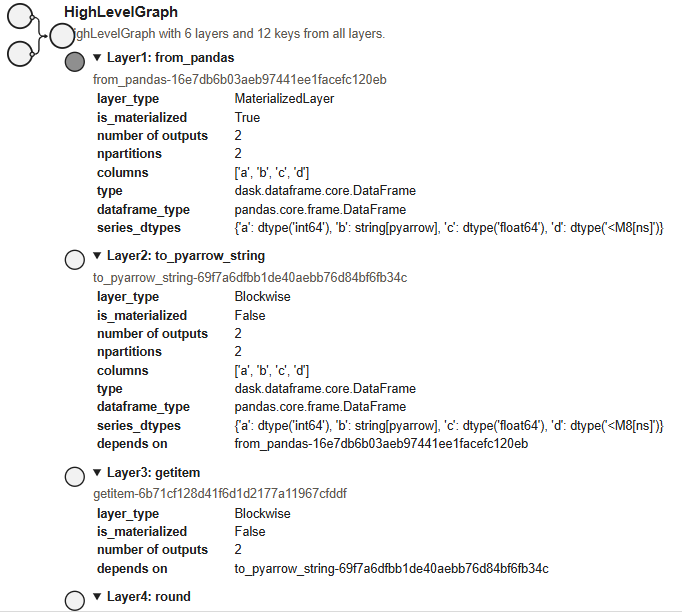
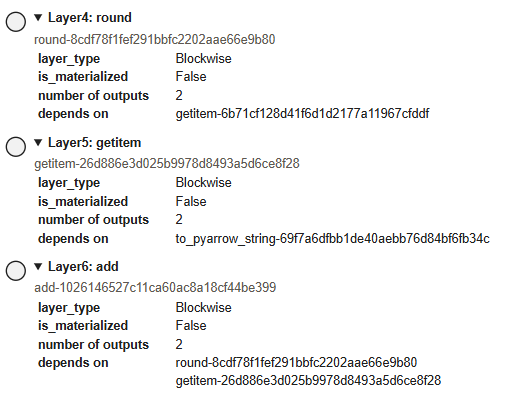

# Теперь на реальных данных

In [35]:
df = dd.read_parquet(Path('D:/DF/MitUP/1/tree'), filters=[("day", ">", 17)],  parse_dates=['timestamp'])   
df

,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties,quart,year,month,day
npartitions=2,,,,,,,,,,,,,,,,
,"datetime64[ns, pytz.FixedOffset(-240)]",string,string,string,string,string,string,int64,int64,int64,string,string,int32,category[known],category[known],category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [37]:
df._meta

,timestamp,id,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties,quart,year,month,day


In [39]:
df._meta.dtypes

timestamp     datetime64[ns, pytz.FixedOffset(-240)]
id                                   string[pyarrow]
hostname                             string[pyarrow]
objectID                             string[pyarrow]
object                               string[pyarrow]
action                               string[pyarrow]
actorID                              string[pyarrow]
pid                                            int64
ppid                                           int64
tid                                            int64
principal                            string[pyarrow]
properties                           string[pyarrow]
quart                                          int32
year                                        category
month                                       category
day                                         category
dtype: object

In [41]:
df.divisions

(None, None, None)

In [43]:
df = df.set_index('id')

In [45]:
df.divisions

('0000ad26-9f76-45a1-b0b6-2f52573e24e4',
 '6b318fd9-1cd7-4636-b1e0-f8e1d18f5979',
 'ffffb4fa-cd73-4a7e-b07d-b9e3e0bbd282')

## Groupby
По-умолчанию при группировке Dask переопределяет число выходных partitions. Но можно задать его принудительно с помощью аргумента split_out.

In [47]:
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

In [51]:
result = df.groupby(['hour', 'day'], observed=False).minute.mean()
result.npartitions

1

In [53]:
result = df.groupby(['hour', 'day'], observed=False).minute.mean(split_out = 2)
result.npartitions

2

In [55]:
%%time
#Расчет распределения записей по часам
objects_freq = df.groupby(['hour', 'minute']).agg(total = ('hostname', 'count'))
objects_freq['prs'] = objects_freq['total']/objects_freq['total'].sum()

CPU times: total: 15.6 ms
Wall time: 15.5 ms


In [69]:
stat = objects_freq.compute().reset_index()
# stat.reset_index().plot(kind = 'bar', y = 'prs', x = 'hour');
stat = stat.assign(m_gr = lambda dx: np.where(dx.minute <= 30, 1, 2))

<Axes: xlabel='hour', ylabel='total'>

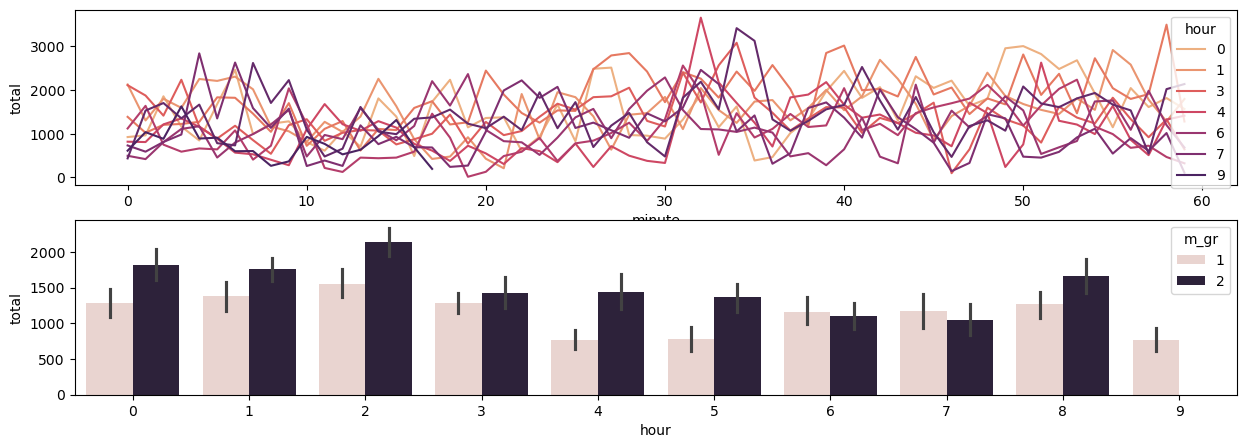

In [71]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 5))
sns.lineplot(stat, x = 'minute', y = 'total', hue = 'hour',  palette="flare", ax = ax[0])
sns.barplot(stat, x="hour", y="total", hue="m_gr", ax = ax[1])

## Агрегация с кастомной функцией

In [75]:
#Задаем функцию через класс Aggregation
nunique = dd.Aggregation(
    name="nunique",
    chunk=lambda s: s.apply(lambda x: list(set(x))),
    agg=lambda s0: s0.obj.groupby(level=list(range(s0.obj.index.nlevels))).sum(),
    finalize=lambda s1: s1.apply(lambda final: len(set(final))),
)

In [77]:
%%time
#Применяем к данным
df.groupby('hour').agg(pid_uniq = ('pid', nunique), 
                       record_total = ('pid', 'count'),
                       ppid_uniq = ('ppid', nunique),
                       hostname_unique = ('hostname', nunique),
                       principal_unique = ('principal', nunique),
                       objectID_unique = ('objectID', nunique),
                       actorID_unique = ('actorID', nunique),
                      ).compute()

CPU times: total: 3.45 s
Wall time: 3.55 s


,pid_uniq,record_total,ppid_uniq,hostname_unique,principal_unique,objectID_unique,actorID_unique
hour,,,,,,,
0,60,92818,59,20,22,46409,61
1,53,93826,52,18,18,46913,53
2,62,109912,61,18,18,54956,63
3,47,81194,45,17,17,40597,47
4,55,64672,57,18,18,32336,57
5,54,63578,56,17,18,31789,57
6,64,68066,63,18,18,34033,64
7,53,66598,51,18,18,33299,54
8,52,87498,53,18,18,43749,53


## Pivot-table

In [79]:
%%time
df['n'] = 1
df['hostname'] = df['hostname'].astype('category')
df['hostname'] =df['hostname'].cat.as_known()

# Используем pivot_table для создания сводной таблицы
pt = df.pivot_table(
    index='principal',
    values='n',  # Столбцы, значения которых будут аггрегированы
    columns = 'hostname',
    aggfunc = 'sum'
)

# Вычисляем результат и выводим его
result = pt.compute()
result.head(20)

CPU times: total: 4.52 s
Wall time: 3.32 s


hostname,SysClient0101.systemia.com,SysClient0102.systemia.com,SysClient0104.systemia.com,SysClient0105.systemia.com,SysClient0106.systemia.com,SysClient0107.systemia.com,SysClient0108.systemia.com,SysClient0109.systemia.com,SysClient0110.systemia.com,SysClient0111.systemia.com,...,SysClient0115.systemia.com,SysClient0116.systemia.com,SysClient0117.systemia.com,SysClient0119.systemia.com,SysClient0120.systemia.com,SysClient0121.systemia.com,SysClient0122.systemia.com,SysClient0123.systemia.com,SysClient0124.systemia.com,SysClient0125.systemia.com
principal,,,,,,,,,,,,,,,,,,,,,
NT AUTHORITY\NETWORK SERVICE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,124,0,0
SYSTEMIACOM\abalch,0,0,0,0,0,0,0,9766,0,0,...,0,0,0,0,0,0,0,0,0,0
SYSTEMIACOM\bdelancey,0,0,0,0,0,0,1866,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SYSTEMIACOM\csavard,11262,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SYSTEMIACOM\dakroyd,0,0,0,0,0,0,0,0,0,5314,...,0,0,0,0,0,0,0,0,0,0
SYSTEMIACOM\halywahby,0,0,0,0,0,0,0,0,7210,0,...,0,0,0,0,0,0,0,0,0,0
SYSTEMIACOM\jbraucher,0,14418,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SYSTEMIACOM\jlawrence,0,1540,0,0,0,11458,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SYSTEMIACOM\jnorthrop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,77274,0,0,0,0,0,0


## Трансформация данных при помощи кастомной функции
Лучшее решение - рассчитать столбец отдельно, преобразовать в ДФ и пррисоединить к данным

In [81]:
#Из строки аля json формируем строку с ключами
def calc_properties(element):
    # Преобразование строки в словарь
    try:
        data_dict = eval(element)
    except Exception as e:
        print(f"Произошла ошибка при парсинге строки: {e}")
        data_dict = {}
    return ', '.join(list(data_dict.keys()))

In [83]:
#Считываем столбец с индексом
index_ds = df.index.to_frame().compute()

#Считаем столбец со строками
index_ds['property_keys'] = df['properties'].apply(calc_properties, meta=('properties', 'object')).compute()

#Объединяем в ДФ
df = df.join(index_ds[['property_keys']], how = 'left')

In [84]:
df.property_keys.value_counts().compute()

property_keys
acuity_level, bro_uid, dest_ip, dest_port, direction, image_path, l4protocol, src_ip, src_port    1483928
Name: count, dtype: int64[pyarrow]

## Операции с временными рядами

In [87]:
ds = df.repartition(npartitions=2)
ds = ds.sort_values(by = 'timestamp')
ds = ds.set_index('timestamp')

In [89]:
#Придуманная колонка
ds_index = ds.index.to_frame().compute()
ds_index['sec'] = np.random.sample(ds_index.shape[0])
ds = ds.join(ds_index[['sec']], how = 'left')

In [90]:
ds

,hostname,objectID,object,action,actorID,pid,ppid,tid,principal,properties,quart,year,month,day,hour,minute,n,property_keys,sec
npartitions=4,,,,,,,,,,,,,,,,,,,
2019-09-18 00:00:01.634000-04:00,category[known],string,string,string,string,int64,int64,int64,string,string,int32,category[known],category[known],category[known],int32,int32,int64,string,float64
2019-09-18 04:00:01.633999872-04:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-18 07:31:50.052000-04:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-18 09:17:20.406000-04:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-18 13:17:20.406000128-04:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [93]:
#Отбираем данные с интервалом в 1 секунду, чтобы уменьшить общий размер кадра данных
stat = ds[["sec"]].resample("1s").mean()
stat = stat.compute()

In [95]:
#Отбираем данные с интервалом в 30 секунд, чтобы уменьшить общий размер кадра данных (скользящее среднее)
stat_2 = stat.rolling(window="30s").mean()

<Axes: xlabel='timestamp'>

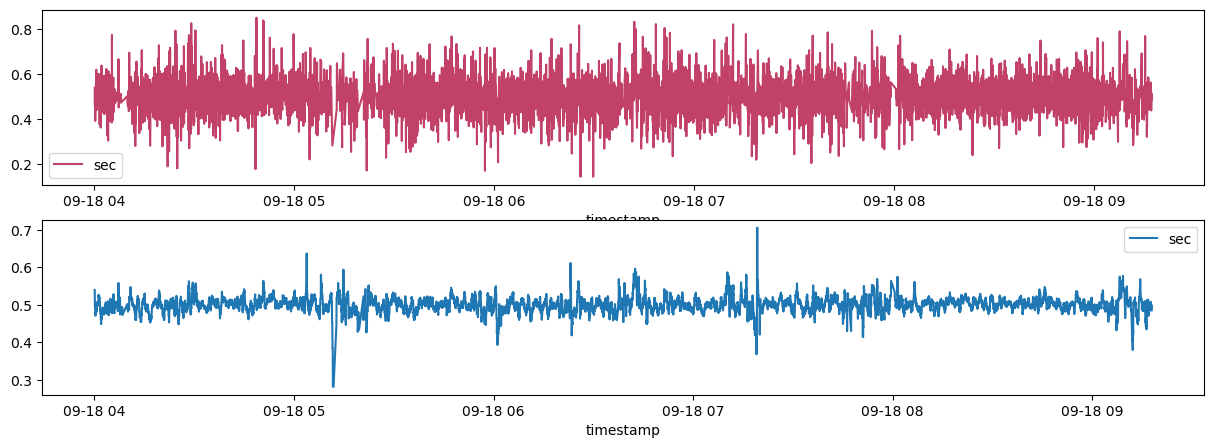

In [97]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 5))
sns.lineplot(stat, palette="flare", ax = ax[0])
sns.lineplot(stat_2, ax = ax[1])

# Dask vs Pandas

In [79]:
gc.collect()
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 7.06 GB


## Dask

In [80]:
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 7.06 GB


In [81]:
%%time
df = dd.read_json(Path('C:/Users/OkCu/Desktop/DF/ecar/AIA-101-125.ecar.json'), errors ='ignore', lines=True, blocksize = 104857600) 
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 7.06 GB
CPU times: total: 125 ms
Wall time: 103 ms


In [82]:
del df
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 7.06 GB


In [83]:
gc.collect()
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 7.06 GB


## Pandas

In [84]:
%%time
df = pd.read_json(Path('C:/Users/OkCu/Desktop/DF/ecar/ecarbro.json'), encoding_errors='strict', lines=True)
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 10.27 GB
CPU times: total: 32 s
Wall time: 32.6 s


In [85]:
del df
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 7.00 GB


In [86]:
gc.collect()
display_memory()

Общее количество ОЗУ: 29.94 GB
Используется ОЗУ: 7.00 GB


# А что с очень большими данными ?

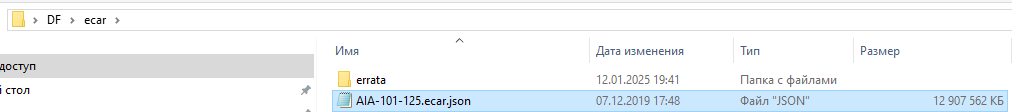

## Чтение файла 

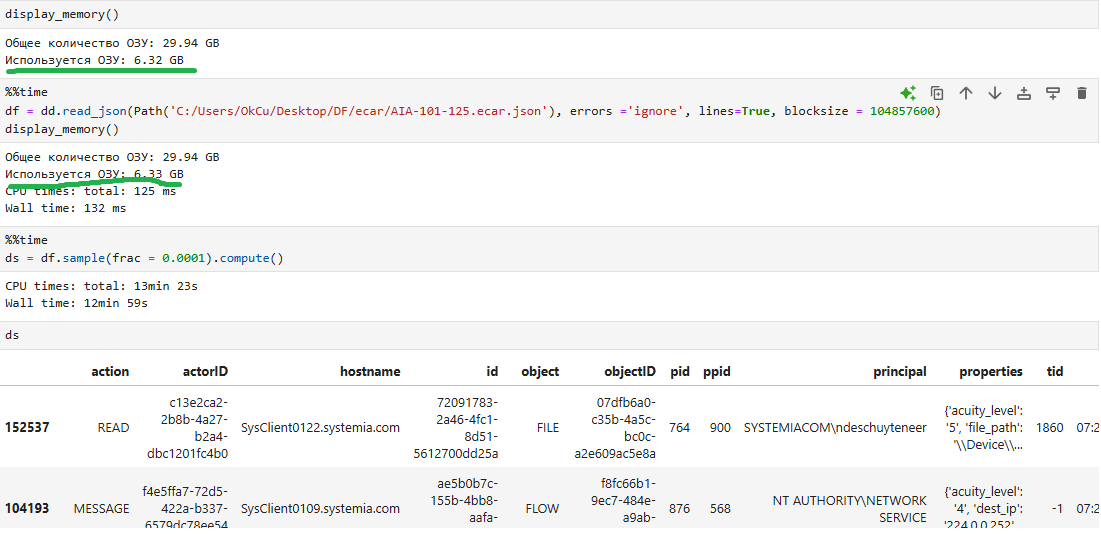

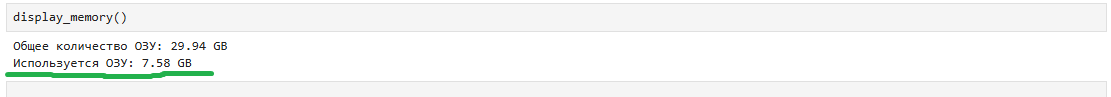

## Groupby

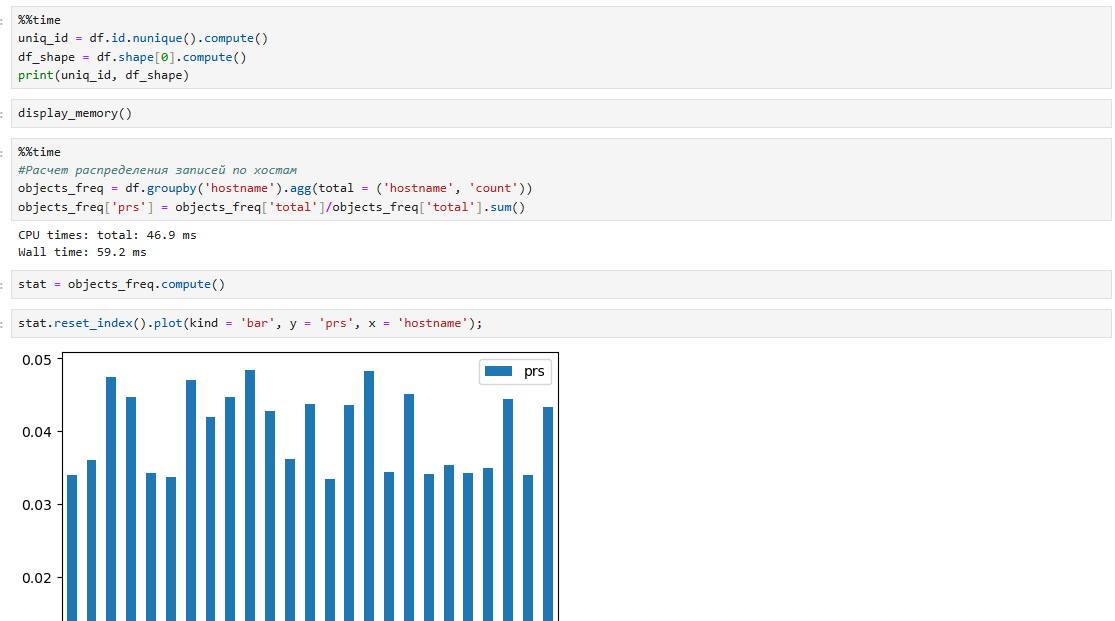

## Агрегация

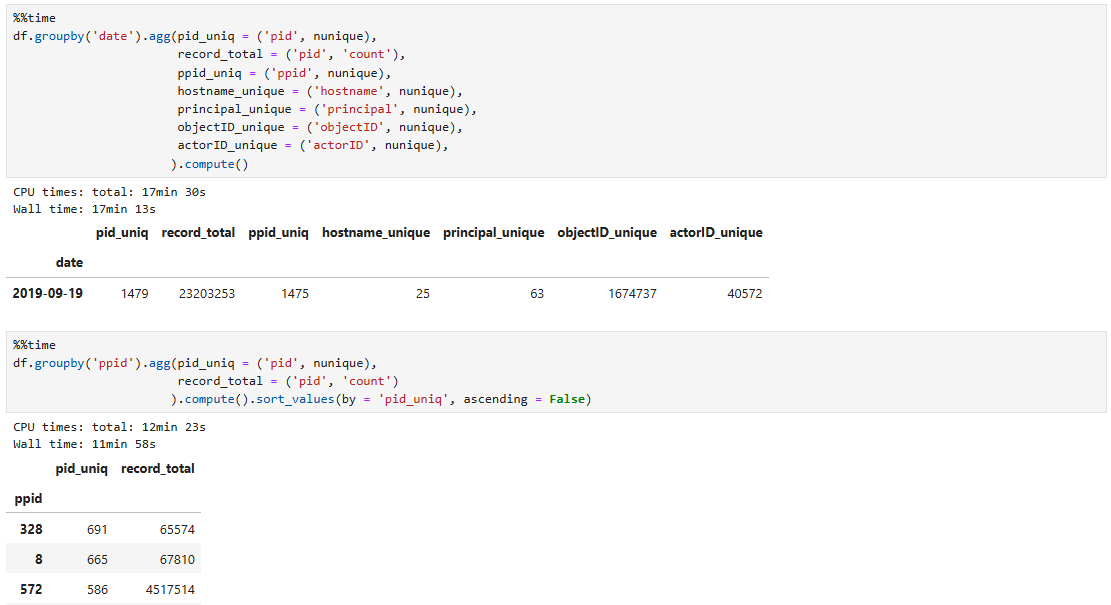

## Pivot

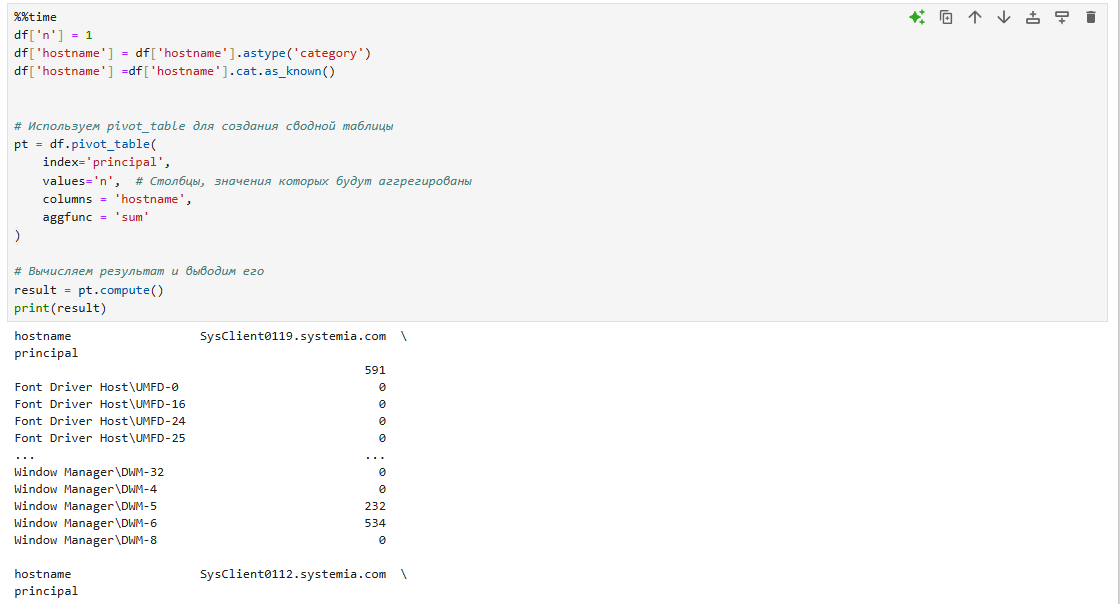

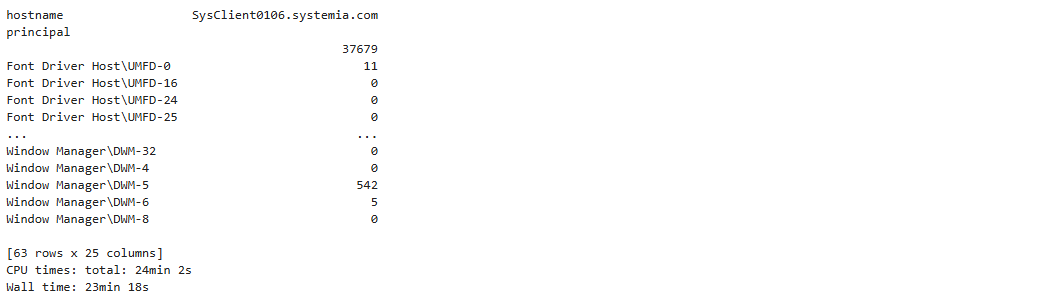

## Кастомная функция

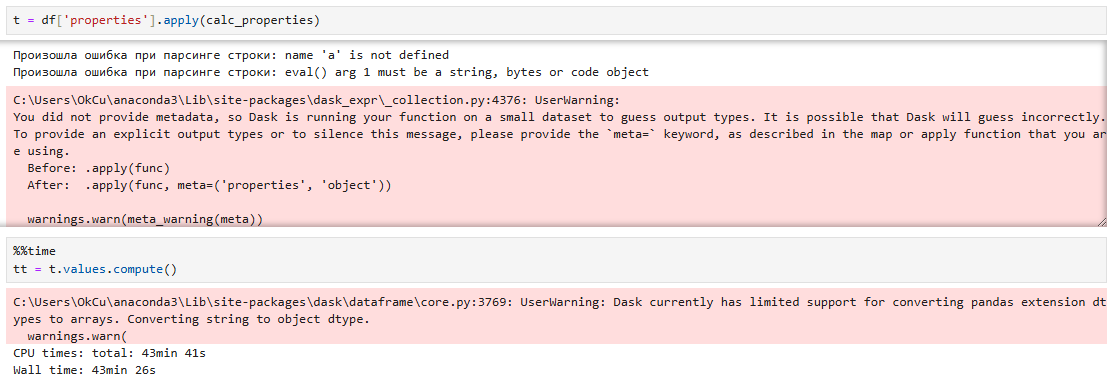